# Example 5: Optical elements polarimetry

Optical elements polarimetry consists on measuring the influence of an optical element upon a light wave polarization, i.e., its Jones or Mueller matrix of the optical element.

There are different ways of implementing a polarimeter for optical elements. In this example we will describe one of the common ones: the four-axis polarimeter, a polarimeter composed of a circularly-polarized light source, two rotating quarter-wave plates (linear retarders with 90º retardance), two rotating perfect polarizers and a photodetector:

<img src="Optical_elements_polarimeter.png" width=969 height=300>

Most optical element polarimeters, like this one, are usually divided into two parts: the polarization states generator (PSG) and the polarization states analyzer (PSA). The polarization states generator is the part of the polarimeter capable of generating many polarization states. In our case, it is composed by the first rotating polarizer and waveplate. If both of them are perfect elements, this PSG can generate all the possible polarization states. If the incident light wave is circularly polarized, all the generated states will have the same intensity. The second part is the polarization states analyzer (PSA). This part is the same as the light polarimeter described in the previous example. 

In [2]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

from py_pol import degrees
from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix, create_Jones_matrices
from py_pol.stokes import Stokes, create_Stokes
from py_pol.mueller import Mueller, create_Mueller

## Jones formalism

The most general Jones matrix can be described using 4 parameters. One selection of parameters is:

$J=\exp\left(i\Phi\right)\left[\begin{array}{cc}
J_{0} & J_{1}\exp\left(i\delta_{1}\right)\\
J_{2}\exp\left(i\delta_{2}\right) & J_{3}\exp\left(i\delta_{3}\right)
\end{array}\right]$,

where the modules $J_i$ are real and positive and the phases $\delta_i$ and the global phase $\Phi$ are real and range between 0 and 360º. In principle, it is not possible to measure the global phase using an intensity detector without using interferometric techniques, so first we will concentrate in measuring the other parameters:

$J=\left[\begin{array}{cc}
J_{0} & J_{1}\exp\left(i\delta_{1}\right)\\
J_{2}\exp\left(i\delta_{2}\right) & J_{3}\exp\left(i\delta_{3}\right)
\end{array}\right]$.

There are several techniques to determine the 7 remaining parameters of the Jones matrix. Here we are going to implement the method described in "Calibration method to determine the complete Jones matrix of SLMs", J. Hoyo, L.M. Sanchez-Brea and A. Soria-Garcia, Optics and Lasers in Engineering, Volume 151, April 2022, 106914. This method requires performing 10 intensity measurements, varying the rotation angles of the elements of the PSG and PSA, which we can characterize using the bra-ket notation [1]:

1. $I_{1}=\left|\left\langle 0\text{º},0\text{º}\right|J_{sample}\left|0\text{º},0\text{º}\right\rangle \right|^{2}=J_{0}^{2}$,
1. $I_{2}=\left|\left\langle 0\text{º},0\text{º}\right|J_{sample}\left|90\text{º},0\text{º}\right\rangle \right|^{2}=J_{1}^{2}$,
1. $I_{3}=\left|\left\langle 90\text{º},0\text{º}\right|J_{sample}\left|0\text{º},0\text{º}\right\rangle \right|^{2}=J_{2}^{2}$,
1. $I_{4}=\left|\left\langle 90\text{º},0\text{º}\right|J_{sample}\left|90\text{º},0\text{º}\right\rangle \right|^{2}=J_{3}^{2}$,
1. $I_{5}=\left|\left\langle 0\text{º},0\text{º}\right|J_{sample}\left|0\text{º},-45\text{º}\right\rangle \right|^{2}=\left(J_{0}^{2}+J_{1}^{2}+2J_{0}J_{1}\sin\delta_{1}\right)/2$,
1. $I_{6}=\left|\left\langle 0\text{º},0\text{º}\right|J_{sample}\left|45\text{º, 0º}\right\rangle \right|^{2}=\left(J_{0}^{2}+J_{1}^{2}+2J_{0}J_{1}\cos\delta_{1}\right)/2$,
1. $I_{7}=\left|\left\langle 0\text{º},45\text{º}\right|J_{sample}\left|0\text{º},0\text{º}\right\rangle \right|^{2}=\left(J_{0}^{2}+J_{2}^{2}+2J_{0}J_{2}\sin\delta_{2}\right)/2$,
1. $I_{8}=\left|\left\langle 45\text{º},0\text{º}\right|J_{sample}\left|0\text{º},0\text{º}\right\rangle \right|^{2}=\left(J_{0}^{2}+J_{2}^{2}+2J_{0}J_{2}\cos\delta_{2}\right)/2$,
1. $I_{9}=\left|\left\langle 90\text{º},0\text{º}\right|J_{sample}\left|0\text{º},-45\text{º}\right\rangle \right|^{2}=\left[J_{2}^{2}+J_{3}^{2}+2J_{2}J_{3}\sin\left(\delta_{3}-\delta_{2}\right)\right]/2$,
1. $I_{10}=\left|\left\langle 90\text{º},0\text{º}\right|J_{sample}\left|45\text{º},0\text{º}\right\rangle \right|^{2}=\left[J_{2}^{2}+J_{3}^{2}+2J_{2}J_{3}\cos\left(\delta_{3}-\delta_{2}\right)\right]/2$,

where $\left|\phi,\chi\right\rangle$ is the state generated by the PSG, $\left\langle \phi,\chi\right|$ the state analyzed by the PSA (the state with maximum transmission), and $\phi$ and $\chi$ are the azimuth and ellipticity angle. Then, 7 parameters can be calculated from the intensity measurements:

1. $J_{0}=\sqrt{I_{1}}$,
1. $J_{1}=\sqrt{I_{2}}$,
1. $J_{2}=\sqrt{I_{3}}$,
1. $J_{3}=\sqrt{I_{4}}$,
1. $\delta_{1}=\arctan\left(\frac{2I_{5}-I_{1}-I_{2}}{2I_{6}-I_{1}-I_{2}}\right)$,
1. $\delta_{2}=\arctan\left(\frac{2I_{7}-I_{1}-I_{3}}{2I_{8}-I_{1}-I_{3}}\right)$,
1. $\delta_{3}=\arctan\left(\frac{2I_{9}-I_{3}-I_{4}}{2I_{10}-I_{3}-I_{4}}\right)+\delta_{2}$.

Let's simulate the experiment. The first stepp is implementing a function that calculates the intensity depending on the elements angles and another to calculate the matrix parameters from the intensities.

In [12]:
def sample_polarimeter_measurement(Jsample, angleDG, angleRG, angleRA, angleDA):
    """This function simulates the light polarimeter measurements.
    
    Parameters:
        E: Incident light wave Jones vector.
        angleDG: Rotating angle of the diattenuator (polarizer) of the PSG.
        angleRG: Rotation angle of the quarter-wave plate of the PSG.
        angleRA: Rotation angle of the quarter-wave plate of the PSA.
        angleDA: Rotating angle of the diattenuator (polarizer) of the PSA.
        
    Returns:
        I: Measured intensity."""
    # Rotate the optical elements
    E = Jones_vector().circular_light(intensity=2)   # Intensity = 2 produces a normalized light state of intensity 1 after the PSG
    Jdg = Jones_matrix().diattenuator_perfect(azimuth=angleDG)
    Jrg = Jones_matrix().quarter_waveplate(azimuth=angleRG)
    Jra = Jones_matrix().quarter_waveplate(azimuth=angleRA)
    Jda = Jones_matrix().diattenuator_perfect(azimuth=angleDA)
    # Multiply all objects
    E_final = Jda * Jra * Jsample * Jrg * Jdg * E
    # Measure the intensity
    I = E_final.parameters.intensity()
    # Return
    return I

def matrix_parameters(I):
    """This function calculates the parameters of the Jones matrix from the intensity measurements.
    
    Parameters:
        I: Array of intensities.
        
    Returns:
        J0, J1, J2, J3, d1, d2, d3: Matrix parameters."""
    # Calculate modules
    J0, J1, J2, J3 = np.sqrt(I[:4])
    # Calculate phases
    d1 = np.arctan2(2*I[4] - I[1] - I[0], 2*I[5] - I[1] - I[0]) % (360*degrees) 
    d2 = np.arctan2(2*I[6] - I[2] - I[0], 2*I[7] - I[2] - I[0]) % (360*degrees) 
    d3 = (np.arctan2(2*I[8] - I[2] - I[3], 2*I[9] - I[2] - I[3]) + d2) % (360*degrees) 
    # Return
    return J0, J1, J2, J3, d1, d2, d3   

Now we can check if it works.

In [19]:
# Generate a random Jones matrix for the sample
J0, J1, J2, J3 = np.random.rand(4)
d1, d2, d3 = np.random.rand(3) * 360*degrees
Jsample = Jones_matrix().from_components([J0, J1*np.exp(1j*d1), J2*np.exp(1j*d2), J3*np.exp(1j*d3)])

# Calculate the intensities
angleDG = np.array([0, 90, 0, 90, 45, 45, 0, 0, 45, 45]) * degrees
angleRG = np.array([0, 90, 0, 90, 0, 45, 0, 0, 0, 45]) * degrees
angleRA = np.array([0, 0, 90, 90, 0, 0, 0, 45, 90, 90]) * degrees
angleDA = np.array([0, 0, 90, 90, 0, 0, 45, 45, 90, 90]) * degrees
I = sample_polarimeter_measurement(Jsample, angleDG, angleRG, angleRA, angleDA)

# Calculate the matrix parameters
J0_calc, J1_calc, J2_calc, J3_calc, d1_calc, d2_calc, d3_calc = matrix_parameters(I)

# Compare results
print("Comparison between original and calculated parameters:")
original = [J0, J1, J2, J3, d1/degrees, d2/degrees, d3/degrees]
calculated = [J0_calc, J1_calc, J2_calc, J3_calc, d1_calc/degrees, d2_calc/degrees, d3_calc/degrees]
parameter = ["J0", "J1", "J2", "J3", "d1 (deg)", "d2 (deg)", "d3 (deg)"]
for ind in range(7):
    print("- {}:   Original = {:.4f};    Calculated = {:.4f}".format(parameter[ind], original[ind], calculated[ind]))

Comparison between original and calculated parameters:
- J0:   Original = 0.0666;    Calculated = 0.0666
- J1:   Original = 0.6734;    Calculated = 0.6734
- J2:   Original = 0.6419;    Calculated = 0.6419
- J3:   Original = 0.5885;    Calculated = 0.5885
- d1 (deg):   Original = 134.6173;    Calculated = 134.6173
- d2 (deg):   Original = 181.8143;    Calculated = 181.8143
- d3 (deg):   Original = 274.9632;    Calculated = 274.9632


The match is perfect.

## Mueller-Stokes formalism

The method for determining the Mueller matrix of an optical element is similar to the one for Stokes light polarimetry. The k-th measurement of the light polarimeter experiment is:

$S_{f}^{k}=\left[\begin{array}{cccc}
A_{00}^{k} & A_{01}^{k} & A_{02}^{k} & A_{03}^{k}\\
\bullet & \bullet & \bullet & \bullet\\
\bullet & \bullet & \bullet & \bullet\\
\bullet & \bullet & \bullet & \bullet
\end{array}\right]\left[\begin{array}{cccc}
M_{00} & M_{01} & M_{02} & M_{03}\\
M_{10} & M_{11} & M_{12} & M_{13}\\
M_{20} & M_{21} & M_{22} & M_{23}\\
M_{30} & M_{31} & M_{32} & M_{33}
\end{array}\right]\left[\begin{array}{c}
S_{0}^{k}\\
S_{1}^{k}\\
S_{2}^{k}\\
S_{3}^{k}
\end{array}\right]=\left[\begin{array}{c}
I^{k}\\
\bullet\\
\bullet\\
\bullet
\end{array}\right]$.

Being $A^{k}=M_{D2}(\theta_{D2}^{k})*M_{R2}(\theta_{R2}^{k})$ the Mueller matrix of the PSA, $S^k=M_{R1}(\theta_{R1}^{k})*M_{D1}(\theta_{D1}^{k})*S_i$ the Stokes vector generated by the PSG and $M_{ij}$ the elements of the Mueller matrix of the sample. Due to the fact that the detector only measures the intensity, only some parts of the Mueller matrix of the PSA are important (the rest of the parameters are replaced by $\bullet$). Then, if we consider the 16 required measurements:

$\left[\begin{array}{ccc}
A_{00}^{0}S_{0}^{0} & \ldots & A_{03}^{0}S_{3}^{0}\\
\vdots & \ddots & \vdots\\
A_{00}^{16}S_{0}^{16} & \ldots & A_{03}^{16}S_{3}^{16}
\end{array}\right]\left[\begin{array}{c}
M_{00}\\
\vdots\\
M_{44}
\end{array}\right]=\left[\begin{array}{ccc}
b_{0,0} & \ldots & b_{0,16}\\
\vdots & \ddots & \vdots\\
b_{16,0} & \ldots & b_{16,16}
\end{array}\right]\left[\begin{array}{c}
M_{00}\\
\vdots\\
M_{44}
\end{array}\right]=\left[\begin{array}{c}
I^{0}\\
\vdots\\
I^{16}
\end{array}\right]$.

If $b$ is invertible ($\det(b)\neq0$) then $M_{ij}$ can be easily calculated as $M_{ij}=b^{-1}I'$. This condition is satisfied if there are no repeated set of four angles.

Let us reproduce this numerically. Let us define a function that simulates the experiment and calculates the $b$ matrix. Also, we will include an error amplitude which we will use in the future.

In [14]:
def Mueller_polarimeter_measurement(Msample, Mpol, S_ini, angles, Ierror=0):
    """This function simulates the light polarimeter measurements.
    
    Parameters:
        Msample (Mueller): Mueller matrix of the sample.
        Mpol (list): List with the four Mueller objects of the polarimeter: Md1, Mr1, Mr2, Md2.
        Sini (Stokes): Stokes object of the illumination.
        angles (numpy.ndarray): 4xN array with the angles used to perform the measurement.
        Ierror (float): Intensity error amplitude.
        
    Returns:
        Ik: Measured intensities vector.
        b: b matrix."""
    # Extract the information from the input parameters
    N = angles.shape[1]
    Md1, Mr1, Mr2, Md2 = Mpol
    # Rotate the optical elements
    Md1_rotated = Md1.rotate(angle=angles[0,:], keep=True)
    Mr1_rotated = Mr1.rotate(angle=angles[1,:], keep=True)
    Mr2_rotated = Mr2.rotate(angle=angles[2,:], keep=True)
    Md2_rotated = Md2.rotate(angle=angles[3,:], keep=True)
    # Multiply the objects as required
    Sg = Mr1_rotated * Md1_rotated * S_ini
    A = Md2_rotated * Mr2_rotated
    S_final = A * Msample * Sg
    # Measure the intensity
    Ik = S_final.parameters.intensity() + np.random.randn(N) * Ierror
    # Calculate the b matrix
    Ak = A.parameters.matrix()   # Extract the 4x4xN matrix of the Mueller object
    Ak = Ak[0,:,:]   # Extract all the first rows
#     Ak = np.transpose(Ak)   # Transpose so Ak rows corrrespond to different measurements
    Sk = Sg.parameters.matrix()   # Extract the 4xN matrix of the Stokes object
#     Sk = np.transpose(Sk)   # Transpose so Sk rows corrrespond to different measurements
    b = np.zeros((N,16))
    for ind in range(N):
        b[ind,:] = np.outer(Ak[:,ind], Sk[:,ind]).flatten()
    # Return
    return Ik, b

Now, we can perform the experiment and see if the calculated Mueller matrix is correct. We will use as sample the product of a random diattenuator, a random polarizer and a random diagonal diattenuator. We will use a circularly polarized light wave for simplicity.

In [15]:
# Start by defining the polarimeter system
S_ini = Stokes('Light source')
S_ini.circular_light(intensity=1)
Mpol = create_Mueller(('Diattenuator 1', 'Retarder 1', 'Retarder 2', 'Diattenuator 2'))
Mpol[0].diattenuator_perfect(azimuth=0)
Mpol[1].quarter_waveplate(azimuth=0)
Mpol[2].quarter_waveplate(azimuth=0)
Mpol[3].diattenuator_perfect(azimuth=0)

# Create the sample parameters
p1 = np.random.rand() * 0.5 + 0.5
p2 = np.random.rand() * 0.5
alphaD = np.random.rand() * 90*degrees
delayD = np.random.rand() * 360*degrees

R = np.random.rand() * 180*degrees
alphaR = np.random.rand() * 90*degrees
delayR = np.random.rand() * 360*degrees

d = [np.random.rand(), np.random.rand(), np.random.rand()]

# Create the sample 
Md, Mr, Mp = create_Mueller(N=3)
Md.diattenuator_charac_angles(p1=p1, p2=p2, alpha=alphaD, delay=delayD)
Mr.retarder_charac_angles(R=R, alpha=alphaR, delay=delayR)
Mp.depolarizer_diagonal(d=d)

Msample = Md*Mr*Mp
Msample.name = 'Sample'

# Now, define the rotation angles for the optical elements
angles = np.random.rand(4,16) * 180*degrees

# Make the measurements
Ik, b = Mueller_polarimeter_measurement(Msample=Msample, Mpol=Mpol, S_ini=S_ini, angles=angles)

# Calculate the original Mueller matrix
b_inv = np.linalg.inv(b)
Ik = np.reshape(Ik, (16,1))
M_calc = Mueller('Calculated')
M_calc.from_matrix(M=b_inv@Ik)

# Compare the result
print(Msample, M_calc)

Sample = 
[+0.508 -0.018 +0.093 -0.179]   
[-0.407 +0.022 -0.091 +0.230]   
[-0.038 +0.026 -0.069 -0.070]   
[+0.056 +0.016 +0.136 -0.004]   
 Calculated = 
[+0.508 -0.018 +0.093 -0.179]   
[-0.407 +0.022 -0.091 +0.230]   
[-0.038 +0.026 -0.069 -0.070]   
[+0.056 +0.016 +0.136 -0.004]   



As explained in the previous example, experiments are subject to errors. This means that the calculated Mueller matrices will be wrong. However, the error in the calculated matrix can be reduced by oversampling, i.e., taking more than the minimum 16 measurements. In this case, $b$ will be a Nx16 matrix and $I'$ a Nx1 vector. Then, $M_{ij}$ can be calculated using the pseudoinverse of $b$: 

$b^+=(b^T*b)^{-1}*b^T$.

Let us define a function that performs one polarimetry experiment.

In [16]:
def Mueller_polariemter_experiment(N, Ierror):
    """This funcion simulates a polarimetry experiment with errors in the detection.
    
    Parameters:
        N (int): Number of measurements.
        Ierror (float): Intensity error amplitude.
        
    Returns:
        dif (numpy.ndarray): Difference between the calculated and the original array."""
    # Create the sample parameters
    p1 = np.random.rand() * 0.5 + 0.5
    p2 = np.random.rand() * 0.5
    alphaD = np.random.rand() * 90*degrees
    delayD = np.random.rand() * 360*degrees

    R = np.random.rand() * 180*degrees
    alphaR = np.random.rand() * 90*degrees
    delayR = np.random.rand() * 360*degrees

    d = [np.random.rand(), np.random.rand(), np.random.rand()]

    # Create the sample 
    Md, Mr, Mp = create_Mueller(N=3)
    Md.diattenuator_charac_angles(p1=p1, p2=p2, alpha=alphaD, delay=delayD)
    Mr.retarder_charac_angles(R=R, alpha=alphaR, delay=delayR)
    Mp.depolarizer_diagonal(d=d)

    Msample = Md*Mr*Mp
    Msample.name = 'Sample'

    # Now, define the rotation angles for the optical elements
    angles = np.random.rand(4,N) * 180*degrees

    # Make the measurements
    Ik, b = Mueller_polarimeter_measurement(Msample=Msample, Mpol=Mpol, S_ini=S_ini, angles=angles, Ierror=Ierror)

    # Calculate the Stokes vector
    b_T = np.transpose(b)
    b_inv = np.linalg.inv(b_T @ b)
    b_inv = b_inv @ b_T
    Ik = np.reshape(Ik, (N,1))
    M_calc = b_inv @ Ik
    
    # Calculate the difference
    dif = np.linalg.norm(Msample.M.flatten() - M_calc.flatten())

    # Return
    return dif

Now, lets do the experiment many times, changing the number of measurements and the error amplitude. 

In [17]:
# Define some variables
Nstat = 100      # Number of experiments done under the same condition.
I_errors = np.array([0, 0.005, 0.01, 0.02])    # Array of error factors
Ns = np.arange(20, 100, 10)    # Array of the number of measurements
tol = 1e-12
I_wave = 1    # We will maintain this parameter constant so we can compare the errors easily

# Create the result variables
error = np.zeros((Ns.size, I_errors.size))
legend = []

# Make the loops changing the variables
for indI, Ierror in enumerate(I_errors):   # Loop in the error amplitude
    for indN, N in enumerate(Ns):   # Loop in the number of measurements
        # Create the temporal variables
        aux = np.zeros((Nstat))
        # Repeat the same conditions several times
        for indS in range(Nstat):
            # Do the experiment
            dif = Mueller_polariemter_experiment(N=N, Ierror=Ierror);
            # Calculate the errors
            aux[indS] = dif
        # Calculate the mean square error
        error[indN, indI] = np.linalg.norm(aux) / Nstat
    # Create the legend for the plots
    legend += ['Ierror = {} %'.format(Ierror*100)]

Text(0, 0.5, 'MSE')

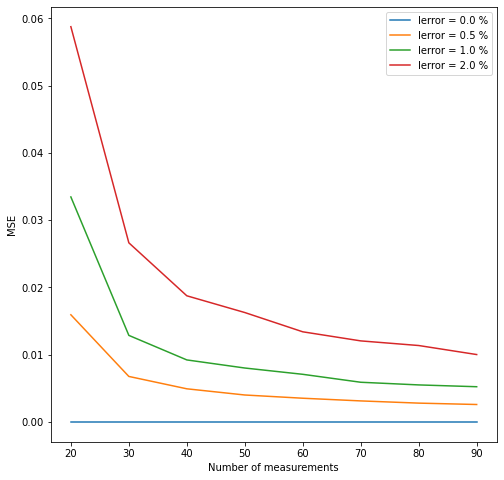

In [18]:
# Plot the results
plt.figure(figsize=(8,8))
plt.plot(Ns, error[:,:])
plt.legend(legend)
plt.xlabel('Number of measurements')
plt.ylabel('MSE')

These plots show that the error in the determiantion of the Stokes vectors is proportional to the initial error amplitude, and can be decreased increasing the number of measurements.